# Functional Connectivity, PGM

In [3]:
import os
import pandas as pd
import numpy as np
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

## Average functional connectivity

In [4]:
connectome_measure = ConnectivityMeasure(kind='correlation')

In [5]:
def extract_data():
    data = []
    for f in os.listdir("PCA_results/"):
        if not f.startswith(".") and f.startswith("sub"):
            data.append(pd.read_csv(os.path.join("PCA_results", f)).values)
    return np.stack(data)

In [6]:
data = extract_data()

In [7]:
correlation = connectome_measure.fit_transform(data)

In [8]:
correlation.shape

(28, 6, 6)

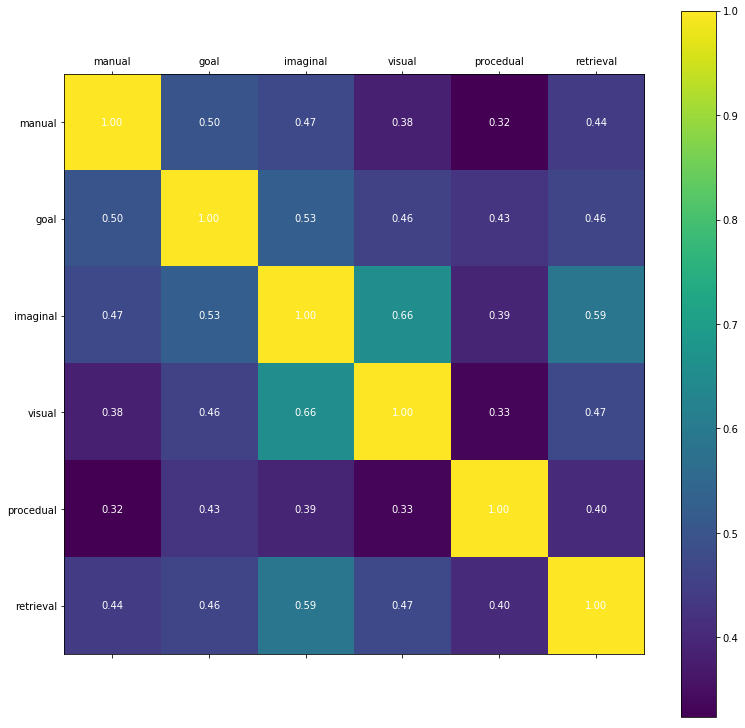

In [9]:
labels = [i[:-7] for i in pd.read_csv("PCA_results/sub-001.csv").columns]
mean_correlation = np.mean(correlation, axis=0) 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mean_correlation)
for i in range(len(mean_correlation)):
    for j in range(len(mean_correlation)):
        text = ax.text(j, i, "{0:.2f}".format(mean_correlation[i, j]), ha="center", va="center", color="w")
fig.colorbar(cax)
fig.set_size_inches(13, 13)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.savefig("mean_func_corr.png", dpi=200)

## PGM Inference

In [65]:
from itertools import combinations
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

In [66]:
df = pd.read_csv("PCA_results/sub-001.csv")
df.columns = [i[:-7] for i in df.columns]

In [68]:
labels = df.columns
X = df.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
df = pd.DataFrame(X, columns=labels)

In [69]:
# add nodes and edges
model = BayesianModel(list(combinations(labels, r=2)))

In [ ]:
model.fit(df)